In [1]:
library(cowplot)
library(magrittr)
library(ggrepel)
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)

results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)

ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweenness = centrality_betweenness(),
           degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))
class(ppi) <- c('igraph', 'tbl_graph')

snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: ggplot2


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       masks m

In [2]:
lasso_genes <- read_tsv(paste0(results, 'lasso/scored_snps.lasso.tsv'), col_types = 'cd', comment = '#') %>%
    filter(beta != 0) %>%
    inner_join(snp2gene, by = 'snp') %>%
    .$gene %>%
    unique

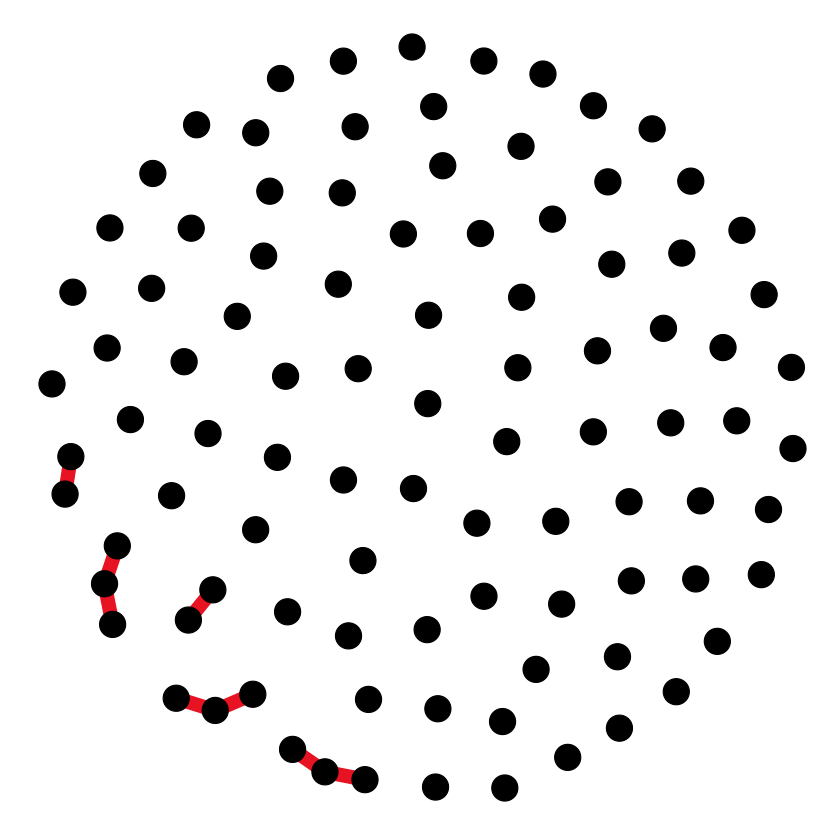

In [3]:
net <- filter(ppi, name %in% lasso_genes) %>%
        ggnetwork %>%
        mutate(name = as.character(name))

nodes <- filter(net, xend == x & yend == y) %>% 
    select(x, y, name) %>%
    unique
edges <- filter(net, xend != x | yend != y)

ggplot() +
    geom_edges(data = edges, aes(x = x, y = y, xend = xend, yend = yend), 
               color = 'firebrick2', size = 4) +
    geom_nodes(data = nodes, aes(x = x, y = y), size = 7) + 
    coord_fixed() +
    theme_blank()

In [4]:
read_tsv(paste0(results, 'lasso/scored_snps.lasso.tsv'), col_types = 'cd', comment = '#') %>%
    filter(beta != 0) %>%
    nrow

[1] 100